In [1]:
import copy

from catboost import CatBoostClassifier
import pickle
import h5py
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sys

from lightning.pytorch.callbacks import EarlyStopping, TQDMProgressBar
from matplotlib import pyplot as plt
from verstack import LGBMTuner
from catboost import CatBoostClassifier, CatBoostRegressor


DATA_DIR = "/home/amh/Documents/Coding/GitHub/AppliedML2023/data/initial"

def load_data(name):
    with h5py.File(f'{name}.h5', 'r') as f:
        filename = name.split('/')[-1]
        return pd.DataFrame(f[filename][:], dtype=np.float32)

train = load_data(f'{DATA_DIR}/train')
test  = load_data(f'{DATA_DIR}/test')

2023-05-19 12:47:52.501166: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 12:47:53.298282: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-19 12:47:53.298368: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-19 12:47:53.298375: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [7]:
with open("/home/amh/Documents/Coding/GitHub/AppliedML2023/data/initial/cat_clf1.pkl", "rb") as f:
    cat_clf = pickle.load(f)

with open("/home/amh/Documents/Coding/GitHub/AppliedML2023/data/initial/classification_variables.txt", "r") as f:
    classification_features = f.read()
    classification_features = classification_features.replace(" ", "").replace("\n", "").replace("'", "").split(",")
train_X = train[classification_features]
train_y = train["Truth"]
test_X = test[classification_features]

train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
cat_clf.fit(train_X, train_y)
test_y_pred = cat_clf.predict_proba(test_X)

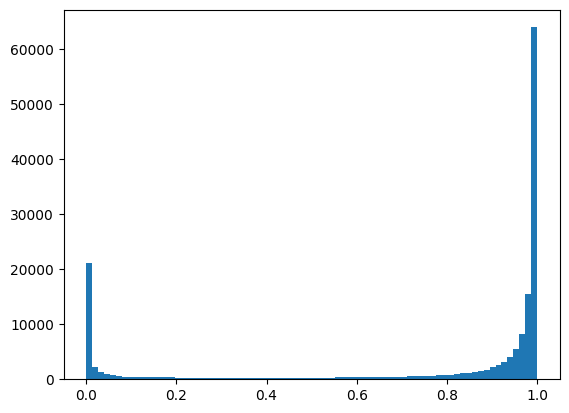

In [8]:
plt.hist(test_y_pred[:, 1], bins="auto")
plt.show()

In [14]:
# Not improving score.
print(cat_clf.score(val_X, val_y))

threshold = 0.9999
low_threshold = 1 - threshold
semi_y = pd.concat([pd.Series(1.0 * (test_y_pred > threshold)[:, 1])[(test_y_pred > threshold)[:, 1]],
                    pd.Series(1.0 * (test_y_pred > low_threshold)[:, 1])[(test_y_pred < low_threshold)[:, 1]],
                    train_y])
semi_X = pd.concat([test_X[(test_y_pred > threshold)[:, 1]],
                    test_X[(test_y_pred < low_threshold)[:, 1]],
                    train_X])

semi_cat_clf = copy.deepcopy(cat_clf)
semi_cat_clf.fit(semi_X, semi_y)



0.9376923076923077
0.9376615384615384
